# **4. Static Coherence Analysis**

In this notebook a functional connectivity (FC) study is performed. The chosen FC metric is the coherence. This notebook consists of 2 parts: 
1. Coherence Networks per frequency band and per trial type (averaged over all subject)
2. Group comparisons (between healthy controls and PwMS)


#### **<font color='red'> Note**: <font color='black'> This Notebook only uses preprocessed data **without** orthogonalisation & **without** sign-flipping 
    
#### **<font color='red'> Note**: <font color='black'> Select only the **first 128 trials** for any epoching and trial-averaging

### **Required input files/folders to run this Notebook**:
- **DIR_parceled_raw**: folder with all fully processed .fif files (from Notebook 1. Preprocessing MEG Python) --> Needed in order to extract event timestamps
- **Parcels_38_names.txt**: .txt file with the names of the 38 parcels of the parcellation file
- **subjectinfo.mat**: file with all clinical patient information 
- **parcellation file**: "fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz" **with 38 parcels** needs to be 4D (3 dimensions for spatial coordinates and 1 for each parcel) with sform_code = 1


#### **Import needed packages**

In [76]:
import os
import glob
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.io import loadmat
import pandas as pd
from IPython import display

import mne
import mne_connectivity
from mne import EpochsArray
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

from osl_dynamics.analysis import connectivity

from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

import nibabel as nib
from nilearn import image, plotting

import scipy 
from scipy.io import loadmat
from scipy.stats import ttest_ind

from itertools import permutations
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

import statsmodels
from statsmodels.stats.multitest import fdrcorrection

#### Extract parcel names for the used parcellation file

In [6]:
## Parcel names extract

# Open the .txt file for reading
file_path = "/home/olivierb/Downloads/Parcels_38_names.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Strip any leading/trailing whitespace and create a list of strings
parcel_names = [line.strip() for line in lines]

# Print the list of strings
print(parcel_names)

## Parcel indices (how the channel names are stored in the Python parceled .fif files)
parcel_idx= []
for i in range(len(parcel_names)):        # 38 parcels
    parcel_idx.append('parcel_' + str(i))
print(parcel_idx)

['L Cuneus', 'R Cuneus', 'L Inf Occ', 'R Inf Occ', 'L Supramarginal', 'R Supramarginal', 'L Sup Temp', 'R Sup Temp', 'L Lat SMC', 'R Lat SMC', 'L Sup Parietal', 'R Sup Parietal', 'L Middle Occ', 'R Middle Occ', 'L Sup Occ', 'R Sup Occ', 'L Ant Temp', 'R Ant Temp', 'L Medial SMC', 'R Medial SMC', 'L Angular', 'R Angular', 'L VL PFC', 'R VL PFC', 'L Occ pole', 'R Occ pole', 'L Sup PFC', 'R Sup PFC', 'L Sup Dorsal PFC', 'R Sup Dorsal PFC', 'L Orbitofrontal', 'R Orbitofrontal', 'L Post Temp', 'R Post Temp', 'L Inf Dorsal PFC', 'R Inf Dorsal PFC', 'Medial PFC', 'Posterior Cingulate Cortex']
['parcel_0', 'parcel_1', 'parcel_2', 'parcel_3', 'parcel_4', 'parcel_5', 'parcel_6', 'parcel_7', 'parcel_8', 'parcel_9', 'parcel_10', 'parcel_11', 'parcel_12', 'parcel_13', 'parcel_14', 'parcel_15', 'parcel_16', 'parcel_17', 'parcel_18', 'parcel_19', 'parcel_20', 'parcel_21', 'parcel_22', 'parcel_23', 'parcel_24', 'parcel_25', 'parcel_26', 'parcel_27', 'parcel_28', 'parcel_29', 'parcel_30', 'parcel_31', 

### **Define some useful functions**

### Load in dataset - fullly processed .fif files for all patients

In [7]:
DIR_parceled_raw = "/home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/"
all_parceled_raw = sorted(glob.glob(DIR_parceled_raw + '*.fif'))

print(len(all_parceled_raw))

wanted_sub_IDs = [subject[-12:-8] for subject in all_parceled_raw]

124


### Remove subjects that should be excluded

In [79]:
## Subjects indices to remove 
# The subjects excluded in the post-processing analyses relate to prior findings by: Master student Sarah Dierickx (2023), PhD student Fahimeh Akbarian from AIMS VUB. 
# As well as additional findings throughout this Thesis (Olivier Burta, 2024):
# - missing DIODE channel (in the event extraction step)
# - missing BUTTON press response channels
# - flat PSD-spectrum
subjects_to_exclude = [0, 5, 38, 41, 49, 62, 68, 83, 84, 106, 107, 114, 119,   # subjects with missing DIODE channel OR having less DIODE events than the amount of trials  
                       30]                                                     # subjects with completely flat PSD spectrum
all_parceled = []

for idx in range(len(all_parceled_raw)):
    if idx not in subjects_to_exclude:
        all_parceled.append(all_parceled_raw[idx])

subject_IDs_group_analysis = []
for idx in range(len(wanted_sub_IDs)):
    if idx not in subjects_to_exclude:
        subject_IDs_group_analysis.append(wanted_sub_IDs[idx])

print(len(subject_IDs_group_analysis))

110


### **Define some useful functions**

In [9]:
# This function extracts all events and additional information from the processed .fif file STIM (= stimulus) channels. 
# It uses the DIODE signal as the stimulus onset (which corresponds to the exact moment each new image is presented to the subject)
def extract_events_from_raw_DIODE(input_fif_data, nr_subject):
    
    button_chans_per_raw = []
    
    ########################################################### 
    
    ##### Read .fif file and extract the event channel layout
    
    raw = mne.io.read_raw_fif(input_fif_data[nr_subject],verbose=False)
    min_duration = 0.005
    events = mne.find_events(raw, stim_channel="STI101",min_duration=min_duration, verbose=False)
    # STI101 is a superposition of all STIM channels, contains all the event types
    
    # Gives an array of all unique event IDs and how many times they occur during the recording (count)
    unique_ids, counts = np.unique(events.T, return_counts=True)
    events_overview = np.asarray((unique_ids, counts))[:,:].T
    
    diode_chan = []
    
    # diode_chan -> STIM channel for the DIODE signal
    # chan_idx -> The first of two BUTTON RESPONSE channel
    
    ## Next line of code causes a problem for those subjects who have a missing diode channel (index = 128)
    # Check if index 128 exists in the first column of events_overview
    if 128 in events_overview[:, 0]:
        chan_idx = np.where(events_overview[:, 0] == 128)[0][0] + 1
        diode_chan = np.where(events_overview[: ,0] == 128)[0][0]
    else:
        # If 128 doesn't exist, set chan_idx to the index of value 2 
        chan_idx = np.where(events_overview[:, 0] == 2)[0][0] + 1
    
        return    # ==> We stop here because the DIODE channel information is ESSENTIAL
    
    # because proceeding events IDs are always 0, 1, 2, 128 (you start at index 4, corresponding to value 256)
    # except for 2 subjects where channels 8 and 72 are active for some strange reason, therefore look for the index corresponding to the location of chan 128
    while events_overview[chan_idx][1] < 20: # 20 = arbitrarely chosen value, used to find one of the channels with the button presses 
                                             # (the first channel that comes after the DIODE channel, AND has sufficient amount of events ==> the first button response channel)
        chan_idx+=1
    
    # we have 2 options:
    # channel is either a [normal power of 2] OR channel is a [power of 2 (+ 128)] 
    # because the first option for a buttton press channel is channel 256:

    # We need 2 button response channels, for correct & incorrect trials. By analysing the channel layout in each subject, the following 2 patterns were identified:
    if events_overview[chan_idx][0]%256 == 0:
        button_chans_per_raw.append([events_overview[chan_idx][0], events_overview[chan_idx][0]*2])         
    elif events_overview[chan_idx][0]%256 == 128:
        button_chans_per_raw.append([events_overview[chan_idx][0], (events_overview[chan_idx][0] - 128)*2 + 128])
    else:
        print('problem')
    # The order is: first INCORRECT, then CORRECT response channel
                        
    ###############################################################################################################

    ##### Extract all trials & button presses
    
    start_time_sample = raw.first_samp

    # Define channel IDs with the requested info (stimuli & response channels)
    event_id_1, event_id_2 = 1,2
    response_ch_1, response_ch_2 = button_chans_per_raw[0] # guaranteed match between response channel for correct & incorrect events

    #### STIM channels
    
    # Without removing the delay-part of the recording OR going from samples --> times
    events_incorr = events[events[:, 2] == event_id_1, 0] 
    events_corr = events[events[:, 2] == event_id_2, 0] 

    incorr = [(timestamp1, "incorrect") for timestamp1 in events_incorr]
    corr = [(timestamp2, "correct") for timestamp2 in events_corr]

    # Merge the channels & sort based on timestamp chronology
    merged_list = incorr + corr
    merged_list.sort(key=lambda x: x[0])
    
    #### DIODE channel

    events_diode = events[events[:, 2] == 128, 0]      # 128 corresponds to DIODE channel index
    
    #### RESPONSE channels
    
     # Get events for the response channels as well
    events_resp_button_incorr = events[events[:, 2] == response_ch_1, 0] 
    events_resp_button_corr = events[events[:, 2] == response_ch_2, 0] 
    
    # Extract timestamps from both response channels and label them (with the baseline response channels)
    timestamps_corr_resp = [(ts, 'correct') for ts in events_resp_button_corr]
    timestamps_incorr_resp = [(ts, 'incorrect') for ts in events_resp_button_incorr]

    # Combine the timestamps and sort them chronologically
    all_timestamps = sorted(timestamps_corr_resp + timestamps_incorr_resp, key=lambda x: x[0])
    
    if len(events_diode) < len(merged_list):
        print('bad')
        return 'bad'


    ##################################################################################################
    
    ##### Define structure of data to be saved per event
    
    col_names_events = ['trial_type', 'epoch_time', 'duration', 'response_type', 'reaction_time', 'epoch_button_time']
    df_rows = []

    # Structure of final dataframe per subject containing info about extracted events:
    # - trial_type (correct / incorrect)
    # - epoch_time (time of stimulus onset)
    # - duration (duration of the trial ==> next_event[0] - event[0])
    # - response_type (ok / mistake / missed)
    # - reaction_time (if missed trial -> assign None)
    # - epoch_button_time (if missed trial -> assign None)

    ##### Run the event info extraction per trial
    
    for i in range(len(merged_list)):
        # Define the array in which to keep all wanted info to put in 1 row of the df_events
        df_row = []

        event = merged_list[i]
        df_row.append('trial_' + event[1])                                         # trial_type
        ###df_row.append(event[0])                                                 # epoch_time

        if i < len(merged_list) - 1:    
            next_event = merged_list[i + 1]
        else:
            next_event = (event[0] + 6 * raw.info['sfreq'], event[1])    # we don't know when the last event of the recording ends, but it can be MAX 6s long
        
        #### DIFFERENT
         ## First find the 1st diode timestamps after the start of the STIM chan
        timestamps_DIODE = [t_DIODE for t_DIODE in events_diode if event[0] < t_DIODE < next_event[0]]
        first_timestamp_DIODE = timestamps_DIODE[0]
        
        df_row.append(first_timestamp_DIODE)                                        # epoch_time 
        df_row.append(next_event[0]-first_timestamp_DIODE)                          # duration
        
        
        #### DIFFERENT
        # Filter timestamps based on the specified time interval
        timestamps_within_interval = [(ts,channel) for ts, channel in all_timestamps if first_timestamp_DIODE < ts < next_event[0]]


        # If a response found in either response channels
        if timestamps_within_interval:

            # Determine the subject's guess based on the first detected button press
            first_button_press, first_channel = timestamps_within_interval[0]

            # If match between event type & what the subject responds
            if first_channel == event[1]:
                df_row.append('trial_' + event[1] + '_r_ok')                                    # response_type
                df_row.append((first_button_press - first_timestamp_DIODE)/raw.info['sfreq'])   # reaction_time
                df_row.append(first_button_press)                                               # epoch_button_time

            # If mismatch between event type & what the subject responds
            else:
                df_row.append('trial_' + event[1] + '_r_mistake')                  # response_type
                df_row.append((first_button_press - first_timestamp_DIODE)/raw.info['sfreq'])   # reaction_time
                df_row.append(first_button_press)                                  # epoch_button_time 

        # If no response found at all
        else:
            df_row.append('trial_' + event[1] + '_r_missed')                       # response_type
            df_row.append(None)                                                    # reaction_time
            df_row.append(None)                                                    # epoch_button_time

        df_rows.append(df_row)

    # Create the DataFrame outside the loop
    df_events = pd.DataFrame(df_rows, columns=col_names_events)

    ## Once this has been done, convert all 'times' as  actual time-unit + take into account weird shift at the beginning        

    # (epoch_time - start_time_sample)/fs
    # duration/fs
    # epoch_button_time - start_time_sample/fs

    df_events['epoch_time'] = (df_events['epoch_time'] - start_time_sample)/raw.info['sfreq'] 
    df_events['duration'] = df_events['duration']/raw.info['sfreq']
    df_events['epoch_button_time'] = (df_events['epoch_button_time'] - start_time_sample)/raw.info['sfreq'] 

    return df_events

In [10]:
# Function to get the get MNE Epochs using the timestamps (expressed in samples, not in time units) from the df_events saved earlier
def get_epochs_per_subject(all_parceled_paths, nr_subject: int, avg: bool, fieldtrip_converted: bool, df_events_all):
    
    ## Extract event timestamps
    #######################################
    
    raw = mne.io.read_raw_fif(all_parceled_paths[nr_subject])
    start_time_sample = raw.first_samp
    
    df_events = df_events_all[nr_subject]
    list_correct = df_events.loc[df_events['trial_type'] == 'trial_correct']['epoch_time'].to_list()      # epoch_time based on diode!
    list_incorrect = df_events.loc[df_events['trial_type'] == 'trial_incorrect']['epoch_time'].to_list()
    
    # Only keep the 38 parcels, remove STIM channels
    ch_names_python = []
    for i in range(38):
        ch_names_python.append('parcel_' + str(i))
    raw = raw.pick(ch_names_python) 
    
    ## Keep 128 first trials
    ######################################

    merged_list = sorted(np.concatenate((list_correct,list_incorrect)))
    
    if len(merged_list) > 128:
        result_elements = merged_list[:128]

        # Remove the elements from list_correct and list_incorrect that do not belong to the first 128 elements of merged_list
        list_correct = [element for element in list_correct if element in result_elements]
        list_incorrect = [element for element in list_incorrect if element in result_elements]
    
    # Extract events -> correction for unwanted time-shift applied here when loading the data
    events_correct = [[raw.time_as_index(timestamp)[0] + start_time_sample, 0, 1] for timestamp in list_correct]
    events_incorrect = [[raw.time_as_index(timestamp)[0] + start_time_sample, 0, 2] for timestamp in list_incorrect]
    
    # Define the parameters for epoching
    tmin = -0.5 
    tmax = 1   

    # Create an Epochs object
    epochs_correct = mne.Epochs(raw, events_correct, event_id=1, tmin=tmin, tmax=tmax, preload=True)
    epochs_incorrect = mne.Epochs(raw, events_incorrect, event_id=2, tmin=tmin, tmax=tmax, preload=True)
    
    # To see which/why some epochs got dropped
    print(epochs_correct.drop_log)
    print(epochs_incorrect.drop_log)
    
    if avg == True:
        return [epochs_correct.average(picks = ch_names_python), epochs_incorrect.average(picks = ch_names_python)]
    else:
        # Concatenate all epochs into a single Epochs instance
        all_epochs = mne.concatenate_epochs((epochs_correct, epochs_incorrect), add_offset=False) #add_offset=False VERY important !! -> otherwise timings become wrong
        print(all_epochs.events)
        
        return all_epochs.pick_channels(ch_names_python)

### **Obtain grand average epochs per subject**

In [ ]:
all_dfs_events = []
for i in range(len(all_parceled)):
    print(i)
    all_dfs_events.append(extract_events_from_raw_DIODE(all_parceled, i))

In [ ]:
## First get averaged epochs for each subject

epochs_all_subjects_avg = []
for i in range(len(subject_IDs_group_analysis)):
    epochs_all_subjects_avg.append(get_epochs_per_subject(all_parceled, nr_subject=i, avg=True, fieldtrip_converted=False, df_events_all=all_dfs_events))

# **Part 1: Global Coherence Networks**

### **Compute Coherence over 5 frequency bands**

In [11]:
import mne_connectivity

# Function using built-in MNE (mne.mne_connectivity.spectral_connectivity_epochs) to compute coherence matrix
def connectivity_per_subject(input_data, method: str, band: str, type_trial: int):
    
    # add method variable implementation => verify if it is part of the array (just like valid_bands)
    # add correct/incorrect trials input + implementation
    
    
    valid_bands = ['delta', 'theta', 'alpha', 'alpha2', 'beta']

    if band not in valid_bands:
        raise ValueError("Invalid band name. Please use one of 'delta', 'theta', 'alpha', or 'beta'.")

    freq_bands = [[1,4],[4,8],[8,10],[10,13],[13,30]]
    selected_band = freq_bands[valid_bands.index(band)]
    
    method = method                                 # For coherence
    fmin = selected_band[0]                         # Minimum frequency
    fmax = selected_band[1]                         # Maximum frequency
    faverage = True                                 # Average over frequencies within the specified range
    #sfreq = grouped_epochs[nr_subject][eventtype].info['sfreq'] # Sampling frequency of your data
    con_mode = 'multitaper'                         # You can choose a different mode if needed
    n_jobs = 1                                      # Number of parallel jobs (adjust as needed)
    
    
    
    ## Problem was: When you say avg=True, it gives you an object of type mne.evoked.EvokedArray object/
    # But mne.connectivity.spectral_connectivity_epochs() needs an mne.epochs.Epochs object as input -> Solution: convert 
    connectivity_epochs_evoked = input_data[type_trial] # Solve this to obtain 1 single epoch for which the coherence should be computed
    
    connectivity_epochs = EpochsArray(np.tile(connectivity_epochs_evoked.data, (1, 1, 1)), connectivity_epochs_evoked.info, 
                                      events=np.column_stack([np.arange(1), np.zeros(1, int), np.ones(1, int)]), tmin=-0.5)

    # Compute spectral connectivity
    coherence = mne_connectivity.spectral_connectivity_epochs(
        connectivity_epochs, method=method, mode=con_mode, fmin=fmin, fmax=fmax,
        faverage=faverage, sfreq=250, n_jobs=n_jobs)

    # Fill in the coherence matrix
    coherence_matrix = np.zeros((38, 38))
    coherence_data = coherence.get_data()

    ## Rows and cols referencing the connectivity matrix
    #for each row
    for i in range(38):
        # for each cholumn
        for j in range(38):
            coherence_matrix[i,j] = coherence_data[i*38+j]
            coherence_matrix[j,i] = coherence_data[i*38+j]

    return coherence_matrix

#### for **Delta** band [1-4] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_DELTA = []

for subject in range(len(epochs_all_subjects_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'delta', type_trial=0))
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'delta', type_trial=1))
    connectivity_all_subs_DELTA.append(connectivity_per_sub)

#### for **Theta**  [4-8] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_THETA = []

for subject in range(len(epochs_all_subjects_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'theta', type_trial=0))
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'theta', type_trial=1))
    connectivity_all_subs_THETA.append(connectivity_per_sub)

#### for **Alpha** band [8-10] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_ALPHA = []

for subject in range(len(epochs_all_subjects_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'alpha', type_trial=0))
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'alpha', type_trial=1))
    connectivity_all_subs_ALPHA.append(connectivity_per_sub)

#### for **Alpha 2** band [10-13] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_ALPHA2 = []

for subject in range(len(epochs_all_subjects_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'alpha2', type_trial=0))
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'alpha2', type_trial=1))
    connectivity_all_subs_ALPHA2.append(connectivity_per_sub)

#### for **Beta** band [13-30]

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_BETA = []

for subject in range(len(epochs_all_subjects_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'beta', type_trial=0))
    connectivity_per_sub.append(connectivity_per_subject(epochs_all_subjects_avg[subject],'coh', 'beta', type_trial=1))
    connectivity_all_subs_BETA.append(connectivity_per_sub)

## Code to split subjects into groups

In [68]:
## First we split the subjects into 2 groups based on the 'subjectinfo.mat'

# Need subject_IDs_group_analysis 

from scipy.io import loadmat
import pandas as pd
import numpy as np

def patientinfo_to_df(patientinfo_mat_path):
    
    array = loadmat(patientinfo_mat_path)['subjectinfo'][0]
    
    indices_relevant_cols = [0,3,4,5,6,7,16,19,21,26]
    relevant_col_names = ['code', 'disdur', 'type', 'age', 'edu', 'SDMT', 'gender_isfemale', 'isms', 'EDSS', 'benzos']
    
    # for each of the relevant columns 
    extracted_out = []
    for column in range(len(indices_relevant_cols)):
        extracted_col = [array[patient][indices_relevant_cols[column]] for patient in range(len(array))]
        extracted_out.append(extracted_col)
    
    df_out = pd.DataFrame()
    for col in range(len(indices_relevant_cols)):
        df_out[relevant_col_names[col]] = extracted_out[col]
    
    # Recursively unpack value from nested arrays 
    def unpack_nested(val):
        if isinstance(val, np.ndarray):
            return unpack_nested(val[0])
        else:
            return val
                    
    df_out = df_out.map(unpack_nested)
    
    return df_out

In [69]:
df_patientinfo = patientinfo_to_df("/home/olivierb/Downloads/subjectinfo.mat")

# Get only 113 subjects for which we have both parceled MEG data & eventtables
filtered_df = df_patientinfo[df_patientinfo['code'].isin(subject_IDs_group_analysis)].reset_index(drop=True)

# Get all row indices with isms = 0 ==> healthy controls
df_control_idx = filtered_df.index[filtered_df['isms'] == 0].tolist()
#print(df_control_idx)
print(len(df_control_idx))

# Get all row indices with isms = 1 ==> MS patients
df_ms_idx = filtered_df.index[filtered_df['isms'] == 1].tolist()
#print(df_ms_idx)
print(len(df_ms_idx))

37
73


## **Seperate data into patient groups / eventtypes !!!**

In [28]:
# Seperate data into groups 

def seperate_into_groups(connectivity_all_subs, control_idx, ms_idx):
    print(np.shape(connectivity_all_subs))
    control_matrices = [connectivity_all_subs[i] for i in control_idx]
    ms_matrices = [connectivity_all_subs[i] for i in ms_idx]

    # Separate data based on task type
    control_correct = [array[0, :, :] for array in np.array(control_matrices)]
    ms_correct = [array[0, :, :] for array in np.array(ms_matrices)]

    control_INcorrect = [array[1, :, :] for array in np.array(control_matrices)]
    ms_INcorrect = [array[1, :, :] for array in np.array(ms_matrices)]
    
    # No groups - all subjects
    all_subjects_correct = [array[0, :, :] for array in np.array(connectivity_all_subs)]
    all_subjects_incorrect = [array[1, :, :] for array in np.array(connectivity_all_subs)]

    return control_correct, ms_correct, control_INcorrect, ms_INcorrect, all_subjects_correct, all_subjects_incorrect

# Seperate data based on frequency band

## Delta 
c_c_DELTA,m_c_DELTA,c_i_DELTA,m_i_DELTA, ALL_DELTA_c, ALL_DELTA_i = seperate_into_groups(connectivity_all_subs_DELTA_test, df_control_idx, df_ms_idx)
## Theta
c_c_THETA,m_c_THETA,c_i_THETA,m_i_THETA, ALL_THETA_c, ALL_THETA_i = seperate_into_groups(connectivity_all_subs_THETA_test, df_control_idx, df_ms_idx)
## Alpha
c_c_ALPHA,m_c_ALPHA,c_i_ALPHA,m_i_ALPHA, ALL_ALPHA_c, ALL_ALPHA_i = seperate_into_groups(connectivity_all_subs_ALPHA_test, df_control_idx, df_ms_idx)
## Alpha 2
c_c_ALPHA2,m_c_ALPHA2,c_i_ALPHA2,m_i_ALPHA2, ALL_ALPHA2_c, ALL_ALPHA2_i = seperate_into_groups(connectivity_all_subs_ALPHA2_test, df_control_idx, df_ms_idx)
## Beta
c_c_BETA,m_c_BETA,c_i_BETA,m_i_BETA, ALL_BETA_c, ALL_BETA_i = seperate_into_groups(connectivity_all_subs_BETA_test, df_control_idx, df_ms_idx)

(110, 2, 38, 38)
(110, 2, 38, 38)
(110, 2, 38, 38)
(110, 2, 38, 38)
(110, 2, 38, 38)


### Get locations of parcel-centers for the 38 parcel data (used to order the parcels for the circular plots)

In [29]:
import nibabel as nib
from nilearn import image, plotting
path_parcel = "/home/olivierb/38_parcels.nii"
nii_img = image.load_img(path_parcel)

# Get the coordinates of all voxels in realistic 3D space
shape = nii_img.shape

# Create a grid of voxel coordinates
x, y, z = np.meshgrid(range(shape[0]), range(shape[1]), range(shape[2]), indexing='ij')

# Stack the voxel coordinates into a single array
voxel_coords = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

# Get the affine matrix
affine = nii_img.affine

world_coords = nib.affines.apply_affine(affine, voxel_coords)

x_min, x_max = np.min(world_coords[:,0]), np.max(world_coords[:,0]) 
y_min, y_max = np.min(world_coords[:,1]), np.max(world_coords[:,1]) 
z_min, z_max = np.min(world_coords[:,2]), np.max(world_coords[:,2])

x_axis = np.arange(x_min, x_max+8, 8)
y_axis = np.arange(y_min, y_max+8, 8)
z_axis = np.arange(z_min, z_max+8, 8)

parcel_centers = []

n_parcels = np.shape(nii_img)[3]
for i in range(n_parcels):
    one_volume_data = image.index_img(nii_img, i).get_fdata()
    location_center = np.where(one_volume_data == np.max(one_volume_data))    # get the peak voxel (highest weight) within the parcel 
    loc = [location_center[axis][0] for axis in range(3)]
    loc_space = [x_axis[loc[0]], y_axis[loc[1]], z_axis[loc[2]]]
    parcel_centers.append(loc_space)

print(parcel_centers)

[[18.0, -94.0, 24.0], [-6.0, -94.0, 24.0], [42.0, -86.0, 0.0], [-38.0, -78.0, -8.0], [58.0, -6.0, 32.0], [-54.0, -6.0, 32.0], [66.0, -22.0, 8.0], [-54.0, -22.0, 8.0], [50.0, -22.0, 56.0], [-38.0, -22.0, 56.0], [26.0, -62.0, 56.0], [-14.0, -70.0, 56.0], [50.0, -70.0, 8.0], [-46.0, -70.0, 8.0], [42.0, -78.0, 40.0], [-30.0, -78.0, 40.0], [50.0, 10.0, -24.0], [-46.0, 10.0, -24.0], [10.0, -30.0, 72.0], [-6.0, -30.0, 72.0], [58.0, -46.0, 40.0], [-54.0, -46.0, 40.0], [50.0, 34.0, 16.0], [-38.0, 34.0, 16.0], [26.0, -94.0, 8.0], [-22.0, -94.0, 8.0], [26.0, 10.0, 56.0], [-22.0, 10.0, 56.0], [18.0, 42.0, 48.0], [-14.0, 42.0, 40.0], [42.0, 50.0, 0.0], [-38.0, 50.0, 0.0], [66.0, -46.0, 0.0], [-54.0, -46.0, 0.0], [26.0, 58.0, 16.0], [-22.0, 50.0, 24.0], [2.0, -62.0, 32.0], [2.0, 50.0, 0.0]]


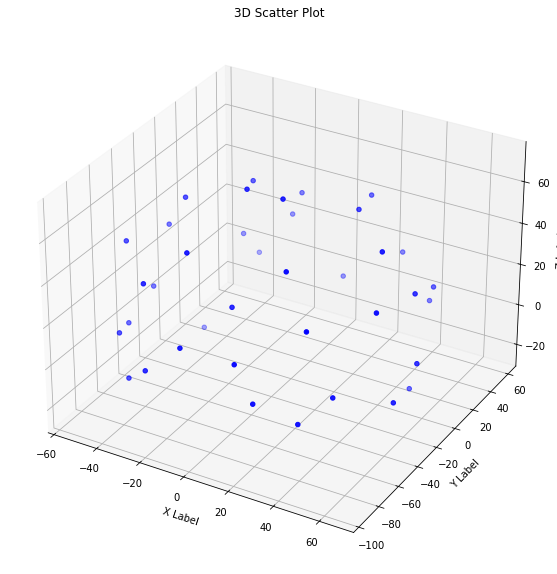

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Extract X, Y, and Z coordinates from the array
x = [parcel_centers[parcel][0] for parcel in range(len(parcel_centers))]
y = [parcel_centers[parcel][1] for parcel in range(len(parcel_centers))]
z = [parcel_centers[parcel][2] for parcel in range(len(parcel_centers))]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='b', marker='o')  # 'c' sets the color, 'marker' defines the marker style

# Set axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('3D Scatter Plot')
plt.show()

In [34]:
# Adapted from: https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_label_connectivity.html
# Function to plot both the circular plot + spatial map of the coherence networks
def plot_spatial_map_connectivity(connectivity_matrix, parcel_names, percentile: int, title: str, image_name: str, network: bool, color: str, y):
    
    ##### PLOT Circular graph
    
    ###  Throw except if shape mismatch between connectivity matrix & amount of parcels
    if np.shape(connectivity_matrix) != (len(parcel_names), len(parcel_names)):
        raise ValueError("Connectivity matrix shape must have same shape as the amount of parcels.")
    
    label_names = parcel_names
    
    ## Add a way to go from the back to the front of the brain (in the ordering, use y-axis parcel centers)
    # without the 2 non-symmetric parcels
    lh_idx = np.arange(0,38,2)
    rh_idx = np.arange(1,39,2)
    
    sorted_indices_lh = lh_idx[np.argsort(np.array(y)[lh_idx])]
    sorted_indices_rh = rh_idx[np.argsort(np.array(y)[rh_idx])]

    lh_labels = []
    rh_labels = []
    
    # Reorder the labels based on their location
    lh_labels = [label_names[i] for i in sorted_indices_lh]
    rh_labels = [label_names[i] for i in sorted_indices_rh]

    # Add the 2 extra parcels
    #lh_labels.append(label_names[36])
    #rh_labels.append(label_names[37])

    # Save the plot order and create a circular layout
    ## Double-checked to make sure that changing anything in the order here doesn't show false results for the fix 38x38 connectivity matrix

    node_order = []
    node_order.extend(lh_labels[::-1])
    node_order.extend(rh_labels)


    node_angles = circular_layout(label_names, node_order, start_pos=90,
                                  group_boundaries=[0, len(label_names) / 2])

    # Plot the graph using node colors from the FreeSurfer parcellation.
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white',   # this color defines the background
                                   subplot_kw=dict(polar=True))

    # Take a % of all strongest connections
    n_lines = 0
    if network:
        n_lines = int((100-percentile)/100*len(label_names)*(len(label_names)-1)/2)
        print(n_lines)
        
        plot_connectivity_circle(connectivity_matrix, label_names, n_lines=n_lines,
                                 node_angles=node_angles, title=title, ax=ax, colormap=color,
                                 facecolor='white', textcolor='black', fontsize_names=12,
                                 fontsize_title=16, padding=7, node_edgecolor='darkgrey', node_colors=[(1,1,1)], node_height=0.9, node_width=2, linewidth=2,
                                 colorbar_size=0.5, colorbar_pos=(-0.3,0.5), fontsize_colorbar=11)

    
    # Count the amount of 1's that will become your n_lines (when plotting the pvalues, not the actual coherence values)
    if not network:
        n_lines = int(np.count_nonzero(connectivity_matrix)/2)
        print(n_lines)
    
        plot_connectivity_circle(connectivity_matrix, label_names, n_lines=n_lines,
                             node_angles=node_angles, title=title, ax=ax, colormap=color,
                             facecolor='white', textcolor='black', fontsize_names=12,
                             fontsize_title=16, padding=7, node_edgecolor='darkgrey', node_colors=[(1,1,1)], node_height=0.9, node_width=2, linewidth=2,
                             colorbar=None)

        
    fig.tight_layout()

    
    if network:
        ##### PLOT connectivity map on 3D brain using parcellation file
        conn_map = connectivity.threshold(connectivity_matrix, percentile=percentile)
    
        connectivity.save(
            conn_map,
            parcellation_file = "/home/olivierb/38_parcels.nii",
            filename = "/home/olivierb/Output_Images_Connectivity/test/" + image_name
        )

    return

### All subjects - DELTA - correct/incorrect

In [38]:
all_DELTA_avg_correct   = np.average(ALL_DELTA_c,axis=0)  
all_DELTA_avg_incorrect = np.average(ALL_DELTA_i,axis=0)  

21


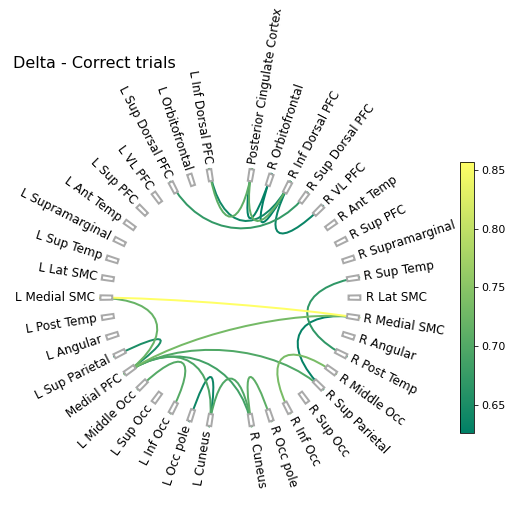

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

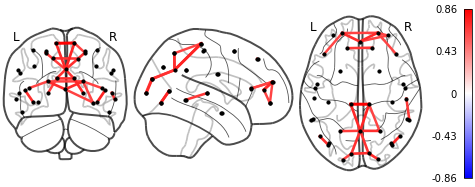

In [39]:
data = all_DELTA_avg_correct
title = 'Delta - Correct trials                                                     '
img_name = 'all_coh_delta_correct'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

21


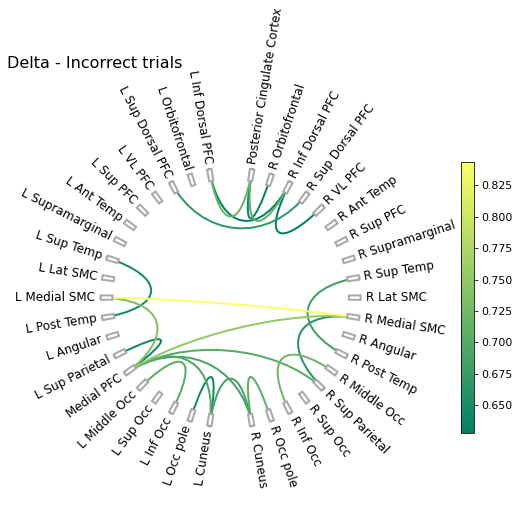

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

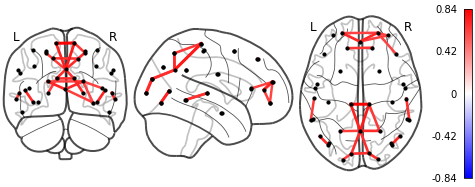

In [40]:
data = all_DELTA_avg_incorrect
title = 'Delta - Incorrect trials                                                     '
img_name = 'all_coh_delta_INcorrect'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

### All subjects - THETA - correct/incorrect

In [41]:
all_THETA_avg_correct   = np.average(ALL_THETA_c,axis=0)  
all_THETA_avg_incorrect = np.average(ALL_THETA_i,axis=0) 

21


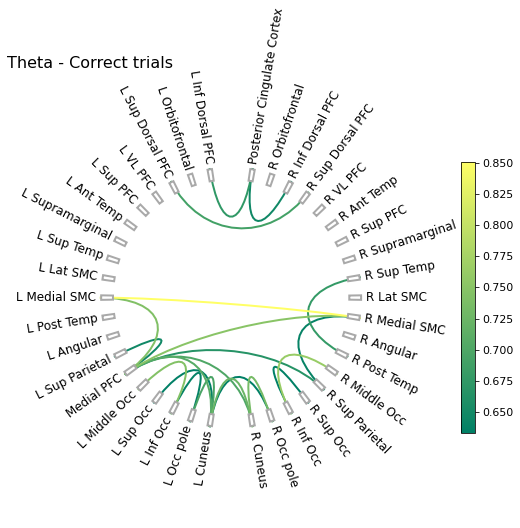

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

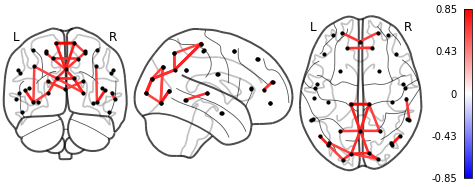

In [42]:
data = all_THETA_avg_correct
title = 'Theta - Correct trials                                                       '
img_name = 'all_coh_theta_correct'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

21


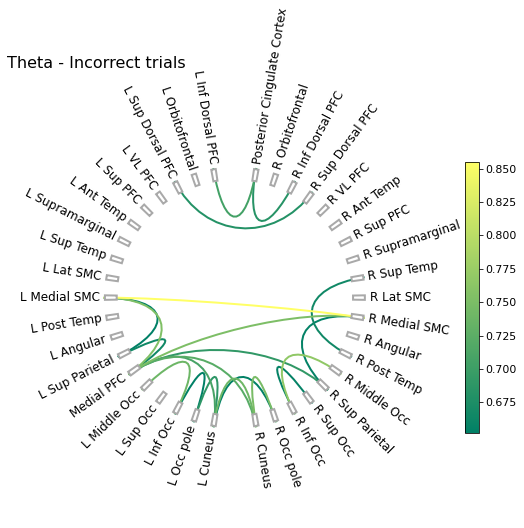

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

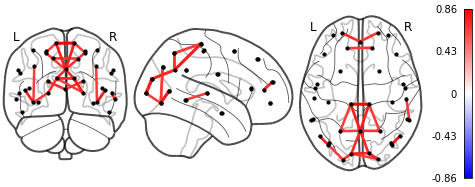

In [44]:
data = all_THETA_avg_incorrect
title = 'Theta - Incorrect trials                                                      '
img_name = 'all_coh_theta_INcorrect'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

### All subjects - ALPHA - correct/incorrect

In [45]:
all_ALPHA_avg_correct   = np.average(ALL_ALPHA_c,axis=0)  
all_ALPHA_avg_incorrect = np.average(ALL_ALPHA_i,axis=0) 

21


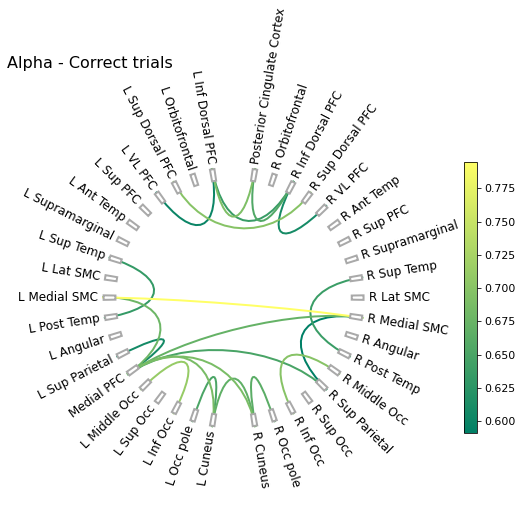

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

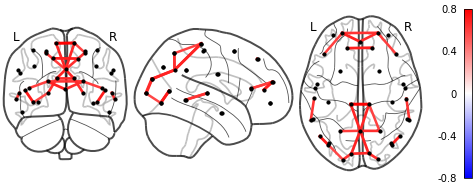

In [46]:
data = all_ALPHA_avg_correct
title = 'Alpha - Correct trials                                                        '
img_name = 'all_coh_alpha_correct'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

21


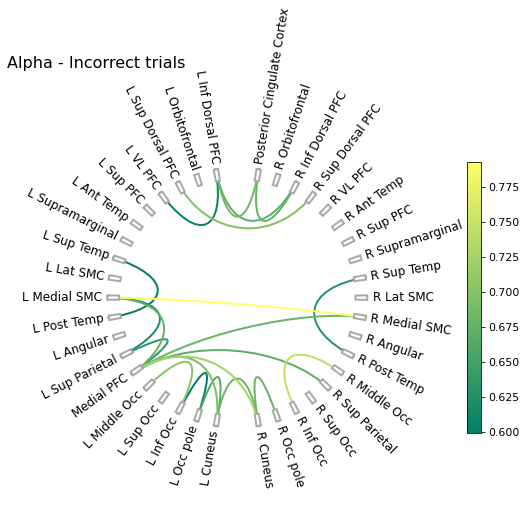

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

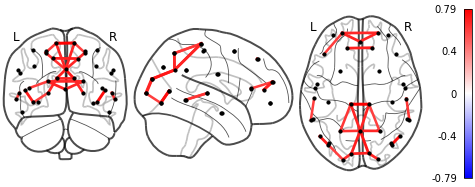

In [55]:
data = all_ALPHA_avg_incorrect
title = 'Alpha - Incorrect trials                                                       '
img_name = 'all_coh_alpha_INcorrect'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

### All subjects - ALPHA 2 - correct/incorrect

In [49]:
all_ALPHA2_avg_correct   = np.average(ALL_ALPHA2_c,axis=0)  
all_ALPHA2_avg_incorrect = np.average(ALL_ALPHA2_i,axis=0) 

21


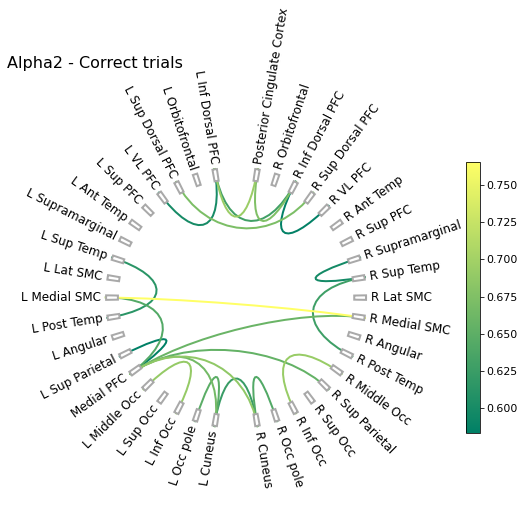

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

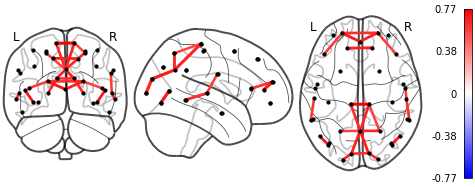

In [50]:
data = all_ALPHA2_avg_correct
title = 'Alpha2 - Correct trials                                                       '
img_name = 'all_coh_alpha2_correct'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

21


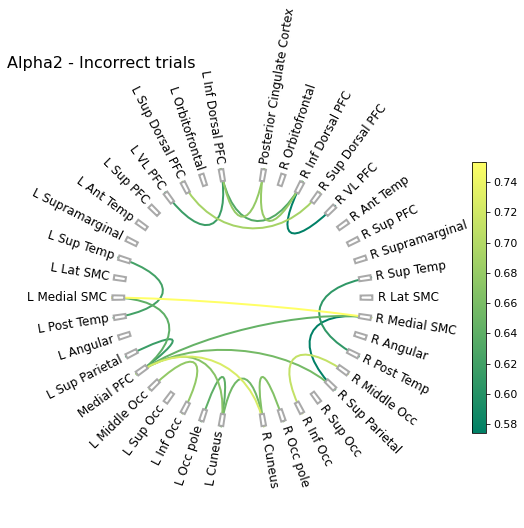

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

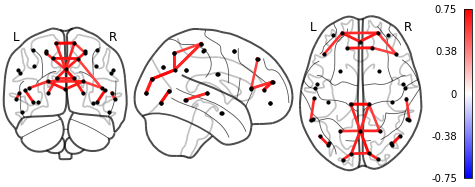

In [51]:
data = all_ALPHA2_avg_incorrect
title = 'Alpha2 - Incorrect trials                                                       '
img_name = 'all_coh_alpha2_INcorrect' 
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

### All subjects - BETA - correct/incorrect

In [52]:
all_BETA_avg_correct   = np.average(ALL_BETA_c,axis=0)  
all_BETA_avg_incorrect = np.average(ALL_BETA_i,axis=0) 

21


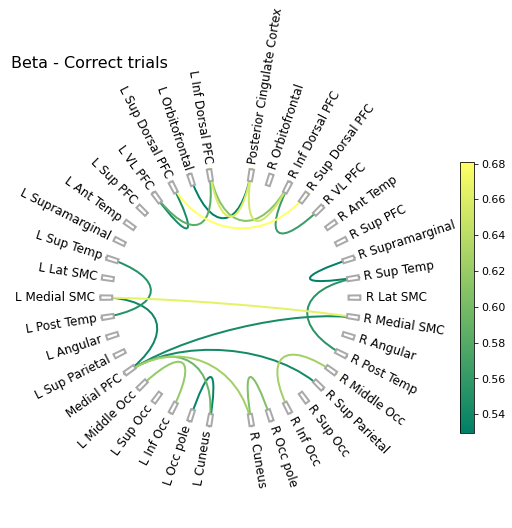

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

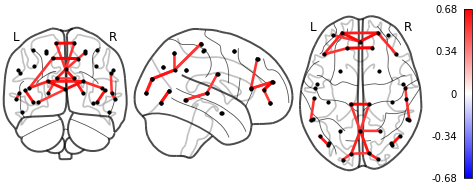

In [53]:
data = all_BETA_avg_correct
title = 'Beta - Correct trials                                                       '
img_name = 'all_coh_beta_correct'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

21


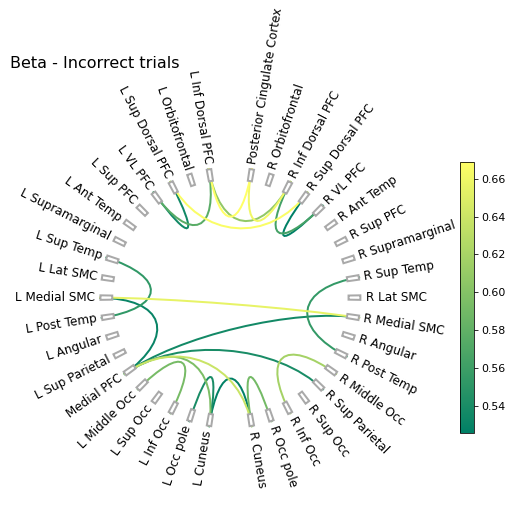

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

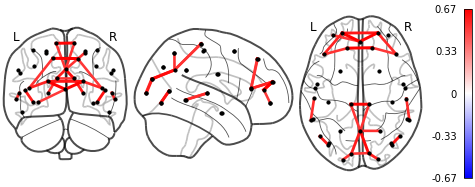

In [54]:
data = all_BETA_avg_incorrect
title = 'Beta - Incorrect trials                                                     '
img_name = 'all_coh_beta_INcorrect'
plot_spatial_map_connectivity(connectivity_matrix=data, parcel_names=parcel_names, percentile=97, 
                              title=title, image_name=img_name, network=True, color='summer', y=y)
display.Image('/home/olivierb/Output_Images_Connectivity/test/' + img_name + '0.png')

# **Part 2: Group-level comparisons**

## **Alternative Approach: Collapsing of Brain Regions**

#### First a bit of code to calculate the Average/1st PCA component for the grand averages of 1 brain region (e.g. occipital) 

In [13]:
## First get non-averaged epochs for each subject

epochs_all_subjects_no_avg = []
for i in range(len(subject_IDs_group_analysis)):
    epochs_all_subjects_no_avg.append(get_epochs_per_subject(all_parceled, nr_subject=i, avg=False, fieldtrip_converted=False, df_events_all=all_dfs_events))

Opening raw data file /home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/parc_0925_raw.fif...
    Range : 26250 ... 325749 =    105.000 ...  1302.996 secs
Ready.
Not setting metadata
61 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 61 events and 376 original time points ...
0 bad epochs dropped
Not setting metadata
67 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 67 events and 376 original time points ...
0 bad epochs dropped
((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (),

In [65]:
test = np.average(epochs_all_subjects_no_avg[0][0],axis=0) # for one subject / # for 1 type of trials / # average over the trials
test.shape # 38 x amount of samples 

# List of potential candidate parcels to be part of a certain brain region

# ex. Occipital Cortex
occipital_names = ['L Cuneus',
                   'R Cuneus',
                   'L Inf Occ',
                   'R Inf Occ',
                   'L Sup Occ',
                   'R Sup Occ']

indices = [parcel_names.index(name) for name in occipital_names if name in parcel_names]

print(indices)

[0, 1, 2, 3, 14, 15]


(376, 6)
[0.4106237  0.20934031 0.18091752 0.09566958 0.06779035 0.03565854]


Text(0.5, 1.0, 'All parcels - Correct Trials- Occipital region - 1 subject ')

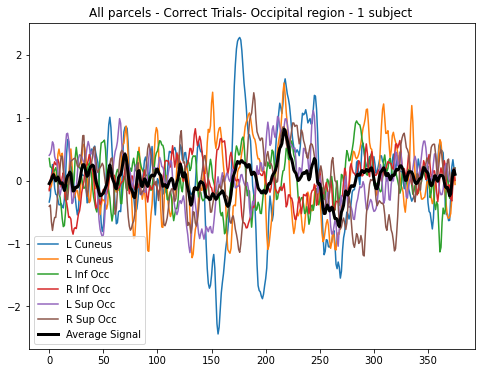

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for index in indices:
    plt.plot(test[index], label=parcel_names[index])

plt.plot(np.average(test[indices], axis=0), color= 'k', linewidth=3, label='Average Signal')    

## PCA part
from sklearn.decomposition import PCA
data_reshaped = np.transpose(testje[indices])
print(data_reshaped.shape)

# Fit the PCA model to your data
num_components = len(indices)
pca = PCA(n_components=num_components)
pca.fit(data_reshaped)

explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

# Select the top 3 components based on variance
selected_components = np.argsort(pca.explained_variance_ratio_)[::-1][:1]   # only get the 1st component

# Transform the data to the reduced dimensional space using all components
data_pca_all = pca.transform(data_reshaped)

plt.legend()
plt.title('All parcels - Correct Trials- Occipital region - 1 subject ')

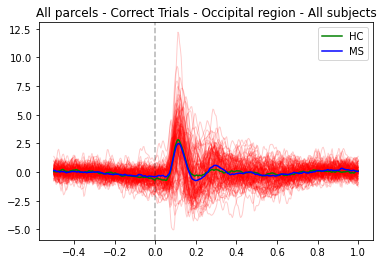

In [71]:
# ex. Occipital Cortex
occipital_names = ['L Cuneus',
                   'R Cuneus',
                   'L Inf Occ',
                   'R Inf Occ',
                   'L Sup Occ',
                   'R Sup Occ']

indices = [parcel_names.index(name) for name in occipital_names if name in parcel_names]

fs = 250
t_start = 0.5
t_end = 1
times = np.arange(-t_start,t_end+1/fs,1/fs)

relevant_comp = []
plt.figure()
for subject in range(len(epochs_all_subjects_no_avg)):
    data = np.average(epochs_all_subjects_no_avg[subject][0],axis=0)
    
    data_reshaped = np.transpose(data[indices])

    # Fit the PCA model to your data
    num_components = len(indices)
    pca = PCA(n_components=num_components)
    pca.fit(data_reshaped)

    explained_variance_ratio = pca.explained_variance_ratio_
    #print(explained_variance_ratio)

    # Select the top 3 components based on variance
    selected_components = np.argsort(pca.explained_variance_ratio_)[::-1][:1]   # only get the 1st component

    # Transform the data to the reduced dimensional space using all components
    data_pca_all = pca.transform(data_reshaped)

    ## Plot the top 1 component
    for i in selected_components:
        #plt.plot(times,data_pca_all[:, i], linewidth=4, label=f'PC{i+1}')
        plt.plot(times,data_pca_all[:, i], linewidth=1, color='r', alpha=0.2)
        relevant_comp.append(data_pca_all[:, i])
    
relevant_comp = np.array(relevant_comp)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.title('All parcels - Correct Trials - Occipital region - All subjects')
#plt.plot(np.average(relevant_comp, axis=0), color='k', linewidth=2, label='Subjects Average')
plt.plot(times,np.average(relevant_comp[df_control_idx], axis=0), color='g', label='HC')
plt.plot(times,np.average(relevant_comp[df_ms_idx], axis=0), color='b', label='MS')
plt.plot()
plt.legend()

### **Define all brain regions (L and R put together)**

In [72]:
occipital_names = ['L Inf Occ',
                   'R Inf Occ',
                   'L Sup Occ',
                   'R Sup Occ']

parietal_names = ['L Sup Parietal',
                  'R Sup Parietal',
                  'L Angular',
                  'R Angular']

temporal_names = ['L Sup Temp',
                  'R Sup Temp',
                  'L Ant Temp',
                  'R Ant Temp']

frontal_names = ['L Sup PFC',
                 'R Sup PFC',
                 'L Sup Dorsal PFC',
                 'R Sup Dorsal PFC',
                 'L Orbitofrontal',
                 'R Orbitofrontal',
                 'L Inf Dorsal PFC',
                 'R Inf Dorsal PFC',
                 'Medial PFC']

medial_names = ['L Cuneus',
                'R Cuneus',
                'Posterior Cingulate Cortex']

brain_region_types = ['Occipital', 'Parietal', 'Temporal', 'Frontal', 'Medial']                       # for plotting title
brain_region_names = [occipital_names, parietal_names, temporal_names, frontal_names, medial_names]   # to get the actual channel indices
indices_all_regions = []
for region in range(len(brain_region_names)):
    indices_all_regions.append([parcel_names.index(name) for name in brain_region_names[region] if name in parcel_names])
                               
print(indices_all_regions)

[[2, 3, 14, 15], [10, 11, 20, 21], [6, 7, 16, 17], [26, 27, 28, 29, 30, 31, 34, 35, 36], [0, 1, 37]]


In [73]:
# Function to collapse (by taking the average or 1st Principal Component) several parcels into 1 brain region (repeated for all 5 brain regions) 
def collapse_parcels(entire_dataset, event_type : str, collapse_metric : str):
    
    # Choose event type
    event_type_idx = 0
    if event_type == 'Correct':
        event_type_idx = 0
    if event_type == 'Incorrect':
        event_type_idx = 1

    fs = 250
    t_start = 0.5
    t_end = 1
    times = np.arange(-t_start,t_end+1/fs,1/fs)

    # Loop over brain regions
    relevant_comps = []
    for region in range(len(brain_region_names)):
        
        relevant_comp_region = []
        plt.figure()
        for subject in range(len(epochs_all_subjects_no_avg)):
            data = np.average(entire_dataset[subject][event_type_idx],axis=0)
        
            ##################### PCA over the relevant parcels ####################
            if collapse_metric == 'PCA':
        
                data_reshaped = np.transpose(data[indices_all_regions[region]])

                # Fit the PCA model to your data
                num_components = len(indices_all_regions[region])
                pca = PCA(n_components=num_components)
                pca.fit(data_reshaped)

                explained_variance_ratio = pca.explained_variance_ratio_

                # Select the top 3 components based on variance
                selected_components = np.argsort(pca.explained_variance_ratio_)[::-1][:1]   # only get the 1st component

                # Transform the data to the reduced dimensional space using all components
                data_pca_all = pca.transform(data_reshaped)

                ## Plot the top 1 component
                for i in selected_components:
                    plt.plot(times,data_pca_all[:, i], linewidth=1, color='r', alpha=0.1)
                    relevant_comp_region.append(data_pca_all[:, i])
    
            ##################### AVG over the relevant parcels ####################
            if collapse_metric == 'Average':
                
                data_retained = data[indices_all_regions[region]]
                data_avg_all = np.average(data_retained, axis=0)
                plt.plot(times, data_avg_all, linewidth=1, color='r', alpha=0.1)
                relevant_comp_region.append(data_avg_all)
        
        relevant_comp_region = np.array(relevant_comp_region)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.title(f'{collapse_metric} - {event_type} Trials - {brain_region_types[region]} - All subjects')
        plt.plot(times,np.average(relevant_comp_region[df_control_idx], axis=0), color='g', label='Healthy Controls')
        plt.plot(times,np.average(relevant_comp_region[df_ms_idx], axis=0), color='b', label='PwMS')
        plt.plot()
        plt.legend()
        
        relevant_comps.append(relevant_comp_region)
    
    return np.array(relevant_comps)

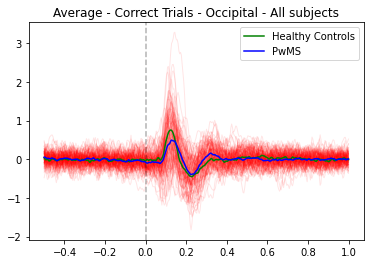

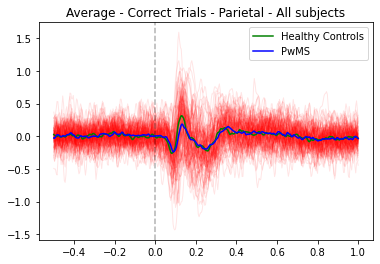

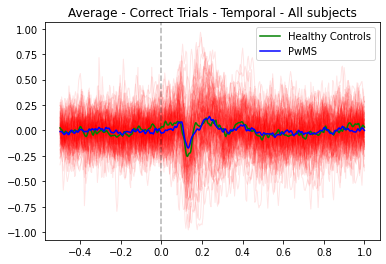

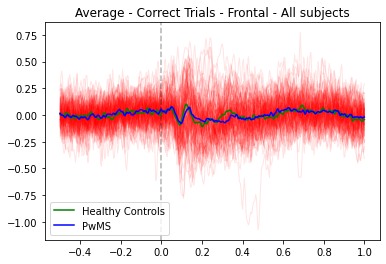

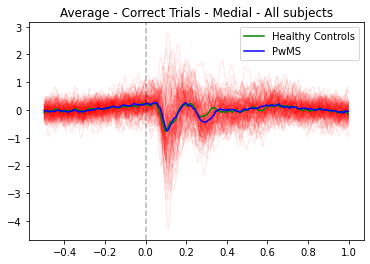

In [74]:
avg_correct = collapse_parcels(epochs_all_subjects_no_avg, event_type = 'Correct', collapse_metric = 'Average')

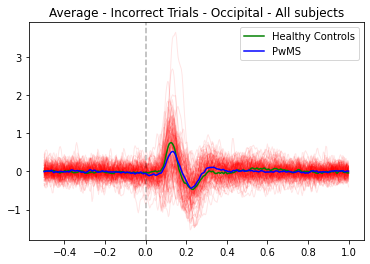

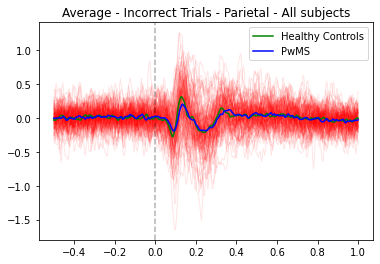

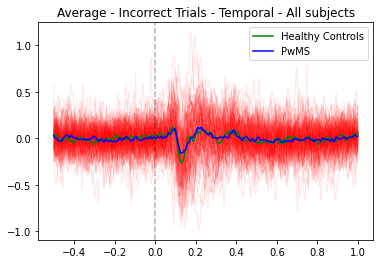

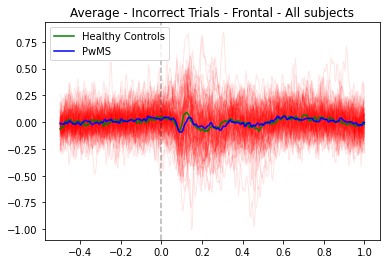

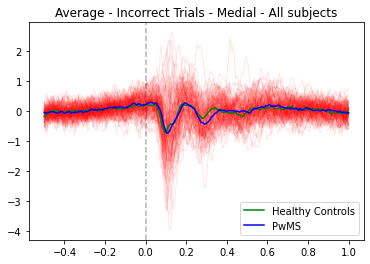

In [75]:
avg_incorrect = collapse_parcels(epochs_all_subjects_no_avg, event_type = 'Incorrect', collapse_metric = 'Average')

## **Group compairons for AVG**

## Coherence on 1 epoch per subject (the average of the parcel AVGs) 

In [64]:
# Function using built-in MNE (mne.mne_connectivity.spectral_connectivity_epochs) to compute coherence matrix
def connectivity_COLLAPSED_per_subject(input_data, method: str, band: str):
    
    # add method variable implementation => verify if it is part of the array (just like valid_bands)
    # add correct/incorrect trials input + implementation
    
    valid_bands = ['delta', 'theta', 'alpha', 'alpha2', 'beta']

    if band not in valid_bands:
        raise ValueError("Invalid band name. Please use one of 'delta', 'theta', 'alpha', or 'beta'.")

    freq_bands = [[1,4],[4,8],[8,10],[10,13],[13,30]]
    selected_band = freq_bands[valid_bands.index(band)]
    
    method = method                                 # For coherence
    fmin = selected_band[0]                         # Minimum frequency
    fmax = selected_band[1]                         # Maximum frequency
    faverage = True                                 # Average over frequencies within the specified range
    con_mode = 'multitaper'                         # You can choose a different mode if needed
    n_jobs = 1                                      # Number of parallel jobs (adjust as needed)
    
    connectivity_epochs = [input_data[:,subject,:]] # Solve this to obtain 1 single epoch for which the coherence should be computed
    
    # Compute spectral connectivity
    coherence = mne_connectivity.spectral_connectivity_epochs(
        connectivity_epochs, method=method, mode=con_mode, fmin=fmin, fmax=fmax,
        faverage=faverage, sfreq=250, n_jobs=n_jobs)

    # Fill in the coherence matrix
    coherence_matrix = np.zeros((5, 5))
    coherence_data = coherence.get_data()

    ## Rows and cols referencing the connectivity matrix
    #for each row
    for i in range(5):
        # for each cholumn
        for j in range(5):
            coherence_matrix[i,j] = coherence_data[i*5+j]
            coherence_matrix[j,i] = coherence_data[i*5+j]

    return coherence_matrix

#### for **Delta** band [1-4] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_DELTA_AVG = []

for subject in range(len(epochs_all_subjects_no_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_correct, method='coh', band='delta'))
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_incorrect, method='coh', band='delta'))
    connectivity_all_subs_DELTA_AVG.append(connectivity_per_sub)

#### for **Theta** band [4-8] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_THETA_AVG = []

for subject in range(len(epochs_all_subjects_no_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_correct, method='coh', band='theta'))
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_incorrect, method='coh', band='theta'))
    connectivity_all_subs_THETA_AVG.append(connectivity_per_sub)

#### for **Alpha** band [8-10] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_ALPHA_AVG = []

for subject in range(len(epochs_all_subjects_no_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_correct, method='coh', band='alpha'))
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_incorrect, method='coh', band='alpha'))
    connectivity_all_subs_ALPHA_AVG.append(connectivity_per_sub)

#### for **Alpha2** band [10-13] Hzha2

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_ALPHA2_AVG = []

for subject in range(len(epochs_all_subjects_no_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_correct, method='coh', band='alpha2'))
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_incorrect, method='coh', band='alpha2'))
    connectivity_all_subs_ALPHA2_AVG.append(connectivity_per_sub)

#### for **Beta** band [13-30] Hz

In [ ]:
# Connectivity per subject, for the 2 trial types (correct/incorrect)
connectivity_all_subs_BETA_AVG = []

for subject in range(len(epochs_all_subjects_no_avg)):
    connectivity_per_sub = []
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_correct, method='coh', band='beta'))
    connectivity_per_sub.append(connectivity_COLLAPSED_per_subject(avg_incorrect, method='coh', band='beta'))
    connectivity_all_subs_BETA_AVG.append(connectivity_per_sub)

In [72]:
print(np.shape(connectivity_all_subs_DELTA_AVG))

(110, 2, 5, 5)


In [73]:
# Seperate data into groups 

def seperate_into_groups(connectivity_all_subs, control_idx, ms_idx):
    print(np.shape(connectivity_all_subs))
    control_matrices = [connectivity_all_subs[i] for i in control_idx]
    ms_matrices = [connectivity_all_subs[i] for i in ms_idx]

    # Separate data based on task type
    control_correct = [array[0, :, :] for array in np.array(control_matrices)]
    ms_correct = [array[0, :, :] for array in np.array(ms_matrices)]

    control_INcorrect = [array[1, :, :] for array in np.array(control_matrices)]
    ms_INcorrect = [array[1, :, :] for array in np.array(ms_matrices)]
    
    # No groups - all subjects
    all_subjects_correct = [array[0, :, :] for array in np.array(connectivity_all_subs)]
    all_subjects_incorrect = [array[1, :, :] for array in np.array(connectivity_all_subs)]

    return control_correct, ms_correct, control_INcorrect, ms_INcorrect, all_subjects_correct, all_subjects_incorrect

# Seperate data based on frequency band

## Delta 
c_c_DELTA_AVG,m_c_DELTA_AVG,c_i_DELTA_AVG,m_i_DELTA_AVG, ALL_DELTA_c_AVG, ALL_DELTA_i_AVG = seperate_into_groups(connectivity_all_subs_DELTA_AVG, df_control_idx, df_ms_idx)
## Theta
c_c_THETA_AVG,m_c_THETA_AVG,c_i_THETA_AVG,m_i_THETA_AVG, ALL_THETA_c_AVG, ALL_THETA_i_AVG = seperate_into_groups(connectivity_all_subs_THETA_AVG, df_control_idx, df_ms_idx)
## Alpha
c_c_ALPHA_AVG,m_c_ALPHA_AVG,c_i_ALPHA_AVG,m_i_ALPHA_AVG, ALL_ALPHA_c_AVG, ALL_ALPHA_i_AVG = seperate_into_groups(connectivity_all_subs_ALPHA_AVG, df_control_idx, df_ms_idx)
## Alpha 2
c_c_ALPHA2_AVG,m_c_ALPHA2_AVG,c_i_ALPHA2_AVG,m_i_ALPHA2_AVG, ALL_ALPHA2_c_AVG, ALL_ALPHA2_i_AVG = seperate_into_groups(connectivity_all_subs_ALPHA2_AVG, df_control_idx, df_ms_idx)
## Beta
c_c_BETA_AVG,m_c_BETA_AVG,c_i_BETA_AVG,m_i_BETA_AVG, ALL_BETA_c_AVG, ALL_BETA_i_AVG = seperate_into_groups(connectivity_all_subs_BETA_AVG, df_control_idx, df_ms_idx)

(110, 2, 5, 5)
(110, 2, 5, 5)
(110, 2, 5, 5)
(110, 2, 5, 5)
(110, 2, 5, 5)


### **Permutation testing (N = 10 000)**

In [174]:
%%time
import numpy as np
from scipy.stats import ttest_ind
from itertools import permutations
from joblib import Parallel, delayed
from sklearn.utils import shuffle

def permutation_test(observed_group1, observed_group2, num_permutations=1000):
    combined_data = np.concatenate((observed_group1, observed_group2))
    n_group1 = len(observed_group1)

    observed_t_stat, _ = ttest_ind(observed_group1, observed_group2)

    count = 1
    
    for _ in range(num_permutations):
        # Shuffle the combined group data
        shuffled_data = shuffle(combined_data)
        
        # Split the shuffled data into two groups
        permuted_group1 = shuffled_data[:n_group1]
        permuted_group2 = shuffled_data[n_group1:]

        # Calculate the t-statistic for the permuted groups
        t_stat, _ = ttest_ind(permuted_group1, permuted_group2)
        
        if t_stat > observed_t_stat:
            count += 1

    # Calculate p-value for the entire permutation test
    p_value = count / (num_permutations+1)
    
    return p_value

CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 52.5 µs


In [175]:
%%time

pval_names = ['delta_correct_AVG',
              'delta_incorrect_AVG',
              'theta_correct_AVG',
              'theta_incorrect_AVG',
              'alpha_correct_AVG',
              'alpha_incorrect_AVG',
              'alpha2_correct_AVG',
              'alpha2_incorrect_AVG',
              'beta_correct_AVG',
              'beta_incorrect_AVG']

groups = [[c_c_DELTA_AVG, m_c_DELTA_AVG],
          [c_i_DELTA_AVG, m_i_DELTA_AVG],
          [c_c_THETA_AVG, m_c_THETA_AVG],
          [c_i_THETA_AVG, m_i_THETA_AVG],
          [c_c_ALPHA_AVG, m_c_ALPHA_AVG],
          [c_i_ALPHA_AVG, m_i_ALPHA_AVG],
          [c_c_ALPHA2_AVG, m_c_ALPHA2_AVG],
          [c_i_ALPHA2_AVG, m_i_ALPHA2_AVG],
          [c_c_BETA_AVG, m_c_BETA_AVG],
          [c_i_BETA_AVG, m_i_BETA_AVG]]


def group_comparison(groups, pval_name):
    
    print(pval_name)
    data_HC = groups[0]
    data_MS = groups[1]
    
    p_values_group = np.ones((5,5))
    count = 0
    for i in range(5):
        for j in range(5):
            if i < j and i != j: # avoid unecessary & symmetrical connections
                print(count)
                count+=1
                connection_index = (i, j)
                observed_values_HC = [sub[connection_index] for sub in data_HC]
                observed_values_MS = [sub[connection_index] for sub in data_MS]
                p_values_group[i, j] = permutation_test(observed_values_HC, observed_values_MS, num_permutations=10000)

    # Save the results, because permutation testing takes a while
    np.save('/home/olivierb/Output_Images_Connectivity/p_values/AVG_collapse/permutation_testing/' + 'group_' + pval_name, p_values_group)

# Now, p_values contains the p-value for each connection

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 38.1 µs


In [ ]:
%%time
for i in range(len(pval_names)):
    group_comparison(groups=groups[i], pval_name=pval_names[i])

### Show results from permutation analysis

In [177]:
def plot_permutation(matrix_path):
    pvals_permuted = np.load(matrix_path)
    print(pvals_permuted)
    # Plot BEFORE multiple comparison correction
    # Set values to 1 where the original values are smaller than 0.05
    new_array = np.zeros((5,5))
    new_array[pvals_permuted < 0.05] = 1
    plt.imshow(new_array)
    plt.title(os.path.basename(matrix_path))
    plt.show()

[[1.         0.00369963 0.16008399 0.22107789 0.26347365]
 [1.         1.         0.03839616 0.03859614 0.10958904]
 [1.         1.         1.         0.01129887 0.1259874 ]
 [1.         1.         1.         1.         0.62753725]
 [1.         1.         1.         1.         1.        ]]


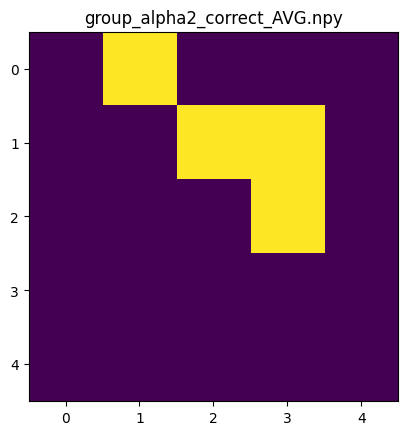

[[1.         0.0469953  0.28747125 0.1129887  0.3089691 ]
 [1.         1.         0.01239876 0.35046495 0.0869913 ]
 [1.         1.         1.         0.02269773 0.04629537]
 [1.         1.         1.         1.         0.2489751 ]
 [1.         1.         1.         1.         1.        ]]


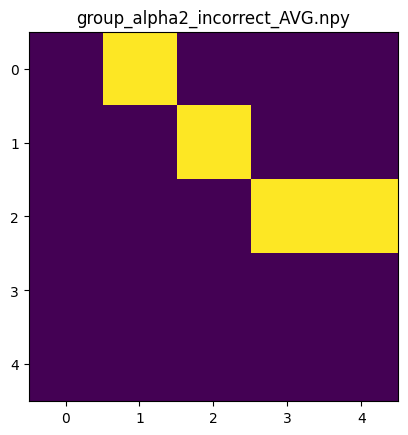

[[1.         0.23167683 0.34836516 0.57254275 0.7590241 ]
 [1.         1.         0.20537946 0.06409359 0.42255774]
 [1.         1.         1.         0.12178782 0.60173983]
 [1.         1.         1.         1.         0.89731027]
 [1.         1.         1.         1.         1.        ]]


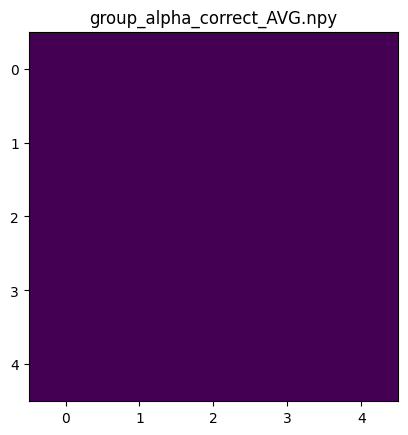

[[1.         0.46515348 0.79772023 0.68553145 0.68673133]
 [1.         1.         0.27687231 0.16268373 0.31556844]
 [1.         1.         1.         0.09139086 0.09759024]
 [1.         1.         1.         1.         0.4339566 ]
 [1.         1.         1.         1.         1.        ]]


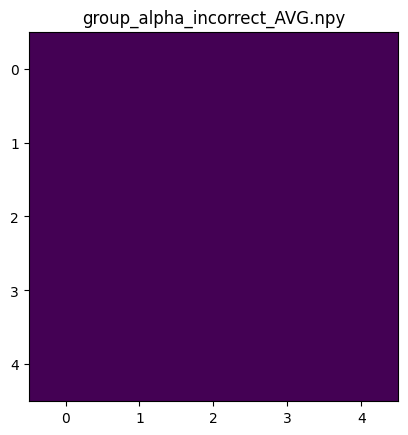

[[1.         0.0749925  0.10558944 0.29607039 0.15858414]
 [1.         1.         0.08329167 0.82381762 0.3449655 ]
 [1.         1.         1.         0.26847315 0.77672233]
 [1.         1.         1.         1.         0.33836616]
 [1.         1.         1.         1.         1.        ]]


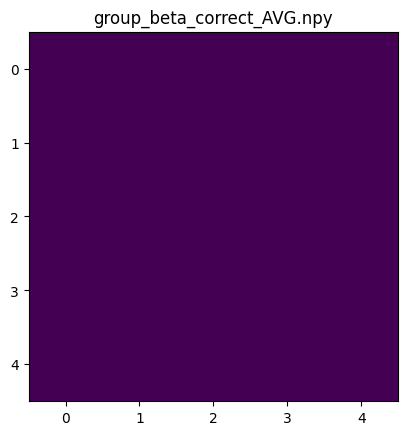

[[1.         0.07889211 0.70762924 0.07039296 0.43205679]
 [1.         1.         0.06359364 0.43885611 0.37046295]
 [1.         1.         1.         0.17288271 0.24387561]
 [1.         1.         1.         1.         0.40265973]
 [1.         1.         1.         1.         1.        ]]


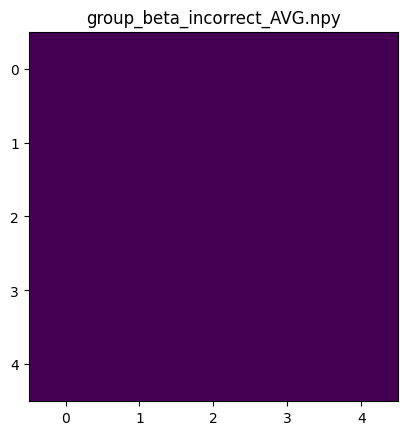

[[1.         0.9040096  0.15858414 0.47485251 0.85631437]
 [1.         1.         0.77552245 0.41905809 0.19998   ]
 [1.         1.         1.         0.35636436 0.69273073]
 [1.         1.         1.         1.         0.71582842]
 [1.         1.         1.         1.         1.        ]]


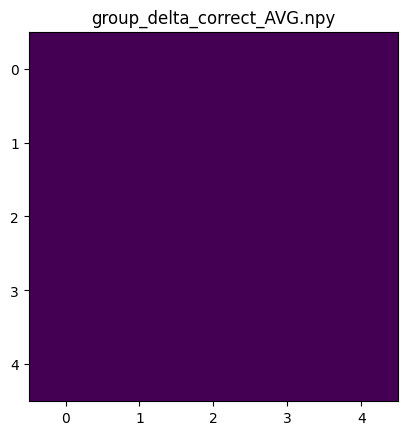

[[1.         0.68183182 0.29547045 0.09749025 0.50914909]
 [1.         1.         0.67873213 0.19568043 0.01479852]
 [1.         1.         1.         0.89631037 0.18888111]
 [1.         1.         1.         1.         0.73492651]
 [1.         1.         1.         1.         1.        ]]


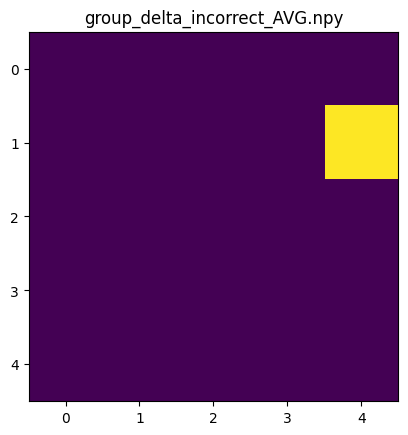

[[1.         0.22107789 0.36536346 0.08609139 0.37616238]
 [1.         1.         0.05819418 0.03529647 0.39436056]
 [1.         1.         1.         0.03859614 0.83851615]
 [1.         1.         1.         1.         0.67693231]
 [1.         1.         1.         1.         1.        ]]


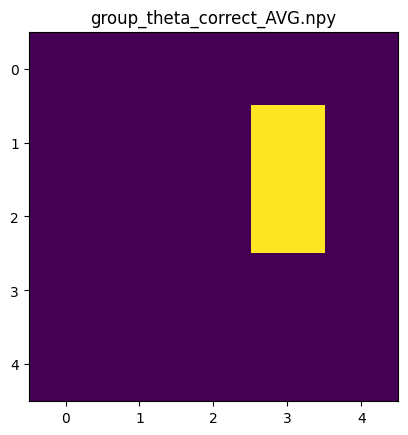

[[1.         0.35926407 0.38576142 0.05969403 0.32136786]
 [1.         1.         0.06189381 0.00229977 0.08079192]
 [1.         1.         1.         0.0039996  0.12538746]
 [1.         1.         1.         1.         0.18458154]
 [1.         1.         1.         1.         1.        ]]


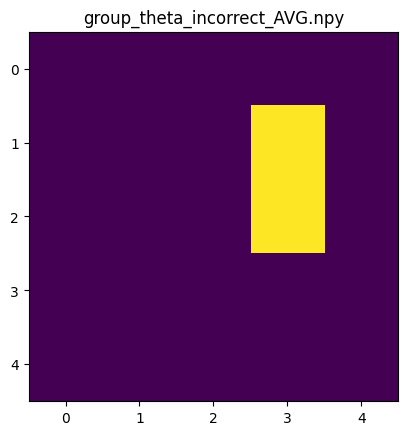

In [178]:
path_permuted_pvals = sorted(glob.glob('/home/olivierb/Output_Images_Connectivity/p_values/AVG_collapse/permutation_testing/' + '*.npy'))
for i in range(len(path_permuted_pvals)):
    test = plot_permutation(path_permuted_pvals[i])

### **mulitple comparison correction (FDR)**

In [179]:
from statsmodels.stats.multitest import fdrcorrection
import statsmodels

def multiple_comparison_correction(matrix_path):
    pvals_permuted = np.load(matrix_path)
    
    # Plot BEFORE multiple comparison correction
    # Set values to 1 where the original values are smaller than 0.05
    new_array = np.zeros((5,5))
    new_array[pvals_permuted < 0.05] = 1
    plt.imshow(new_array)
    plt.title(os.path.basename(matrix_path))
    plt.show()
    
    # Put all pvalues into a 1D-array and keep track of their indices
    pval_input = []
    tuples_coords = []
    for row in range(len(pvals_permuted)):
        for col in range(len(pvals_permuted)):
            if row < col and row != col:
                pval_input.append(pvals_permuted[row][col])
                tuples_coords.append((row, col))
                
    # Apply False Discovery Rate correction for multiple comparison testing
    
    output = scipy.stats.false_discovery_control(pval_input)

    print(len(output[output < 0.05])) # how many connections show stat.significant difference after permutation testing & multiple comparison correction
    print(output[output < 0.05])      # what pvalue do we have there
    print(np.where(output < 0.05)[0]) # get the location indices of this stat.sign. difference connection
    
    # if any p-values < 0.05 after multiple comparison correction
    if len(np.where(output<0.05)[0] > 0):
        for i in range(len(np.where(output<0.05)[0])):
            print(tuples_coords[np.where(output<0.05)[0][i]])
    print(output)
    np.save('/home/olivierb/Output_Images_Connectivity/p_values/AVG_collapse/multiple_comparison_correction/' + os.path.basename(matrix_path), output)
    
    return output, tuples_coords

In [180]:
path_permuted_pvals = sorted(glob.glob('/home/olivierb/Output_Images_Connectivity/p_values/AVG_collapse/permutation_testing/' + '*.npy'))

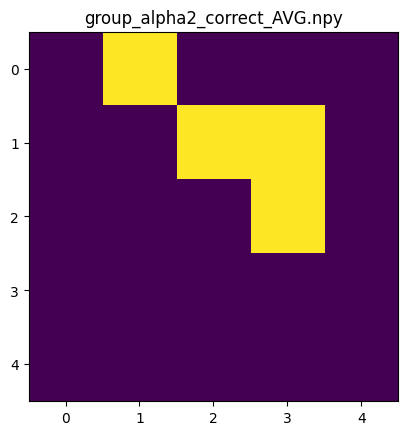

1
[0.0369963]
[0]
(0, 1)
[0.0369963  0.22869142 0.27634737 0.2927485  0.09649035 0.09649035
 0.209979   0.05649435 0.209979   0.62753725]


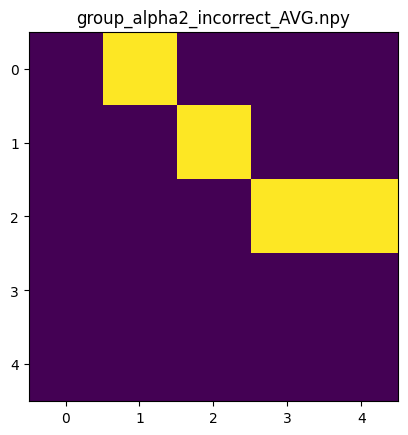

0
[]
[]
[0.11748825 0.343299   0.1883145  0.343299   0.11348865 0.35046495
 0.1739826  0.11348865 0.11748825 0.343299  ]


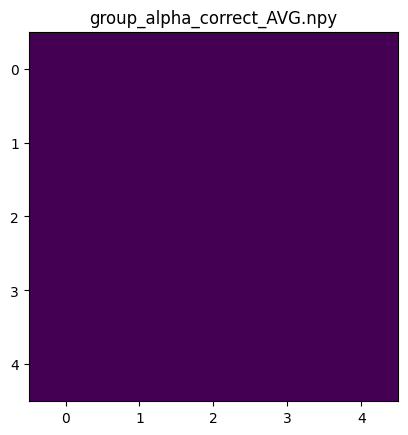

0
[]
[]
[0.57919208 0.69673033 0.75217478 0.84336011 0.57919208 0.57919208
 0.70426291 0.57919208 0.75217478 0.89731027]


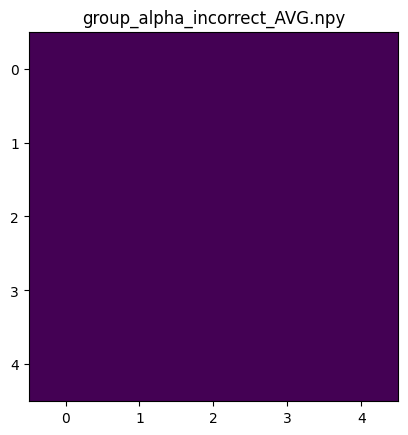

0
[]
[]
[0.66450498 0.79772023 0.76303481 0.76303481 0.63113689 0.54227911
 0.63113689 0.4879512  0.4879512  0.66450498]


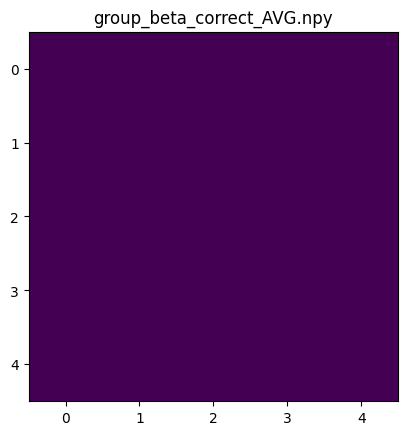

0
[]
[]
[0.3519648  0.3519648  0.43120688 0.39646035 0.3519648  0.82381762
 0.43120688 0.43120688 0.82381762 0.43120688]


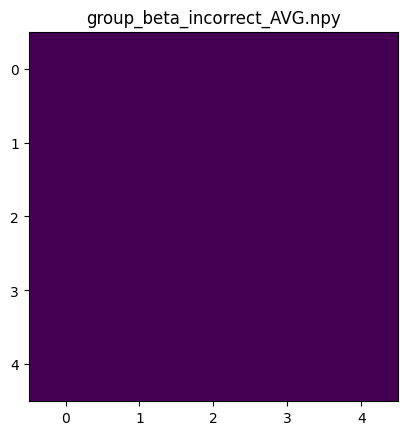

0
[]
[]
[0.2629737  0.70762924 0.2629737  0.4876179  0.2629737  0.4876179
 0.4876179  0.43220678 0.4876179  0.4876179 ]


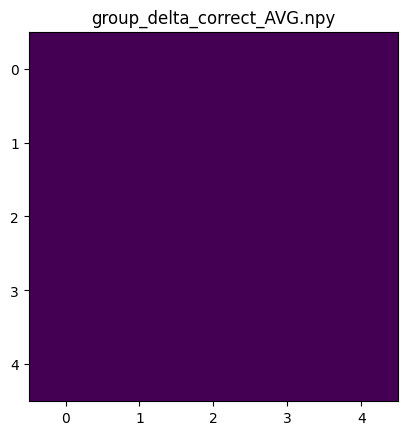

0
[]
[]
[0.9040096 0.9040096 0.9040096 0.9040096 0.9040096 0.9040096 0.9040096
 0.9040096 0.9040096 0.9040096]


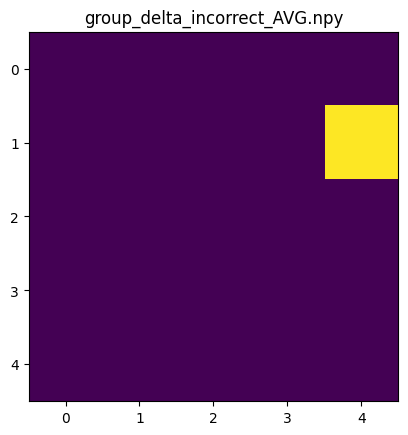

0
[]
[]
[0.81658501 0.59094091 0.48745125 0.81658501 0.81658501 0.48920108
 0.1479852  0.89631037 0.48920108 0.81658501]


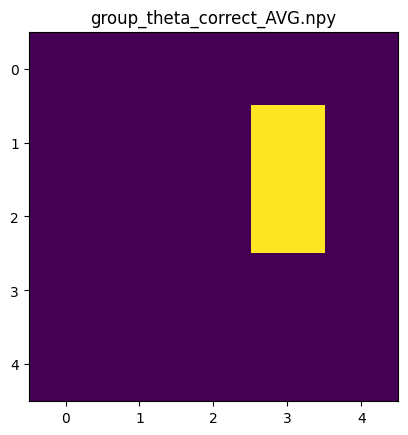

0
[]
[]
[0.44215578 0.4929507  0.21522848 0.4929507  0.1939806  0.1929807
 0.4929507  0.1929807  0.83851615 0.75214701]


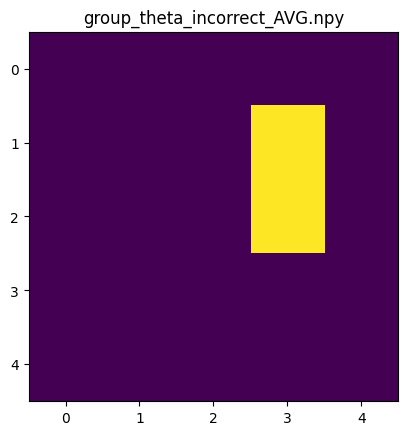

2
[0.019998 0.019998]
[5 7]
(1, 3)
(2, 3)
[0.38576142 0.38576142 0.15473453 0.38576142 0.15473453 0.019998
 0.16158384 0.019998   0.2089791  0.26368792]


In [181]:
for i in range(len(path_permuted_pvals)):
    test = multiple_comparison_correction(path_permuted_pvals[i])

### Verify difference in avg between Healthy Cotnrols vs. PwMS

#### **Statistically significant differences after FDR:**

- **c_ALPHA2_AVG[0,1]**:
    - occipital/parietal
    - p = 0.0370


- **i_THETA_AVG[1,3]**:
    - parietal/frontal
    - p = 0.0200


- **i_THETA_AVG[2,3]**:
    - temporal/frontal
    - p = 0.0200

In [79]:
print('HC:',np.average(c_c_ALPHA2_AVG,axis=0)[0,1], '+/-', np.std(c_c_ALPHA2_AVG,axis=0)[0,1], 
      'PwMS:',np.average(m_c_ALPHA2_AVG,axis=0)[0,1], '+/-', np.std(m_c_ALPHA2_AVG,axis=0)[0,1])
print('HC:',np.average(c_i_THETA_AVG,axis=0)[1,3],  '+/-', np.std(c_i_THETA_AVG,axis=0)[1,3],
      'PwMS:',np.average(m_i_THETA_AVG,axis=0)[1,3], '+/-', np.std(m_i_THETA_AVG,axis=0)[1,3])
print('HC:',np.average(c_i_THETA_AVG,axis=0)[2,3],  '+/-', np.std(c_i_THETA_AVG,axis=0)[2,3],
      'PwMS:',np.average(m_i_THETA_AVG,axis=0)[2,3], '+/-', np.std(m_i_THETA_AVG,axis=0)[2,3])

HC: 0.5246831466194591 +/- 0.17107469301635328 PwMS: 0.4243960935370933 +/- 0.17641366510886058
HC: 0.6503771088373484 +/- 0.1721291580179183 PwMS: 0.5338550705159683 +/- 0.19675169021297678
HC: 0.5623987830096643 +/- 0.1669994349241682 PwMS: 0.4650579835593389 +/- 0.17060277662347786
